In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from helper import split_data, x_cols, y_col
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

random.seed(42)
np.random.seed(42)

In [2]:
df = pd.read_csv('data/mnp-data.csv', low_memory=False)
train_df, valid_df, test_df, oot_df = split_data(df, transform=True)

In [3]:
train_df.shape, valid_df.shape, test_df.shape, oot_df.shape

((45247, 47), (15082, 47), (15083, 47), (14219, 47))

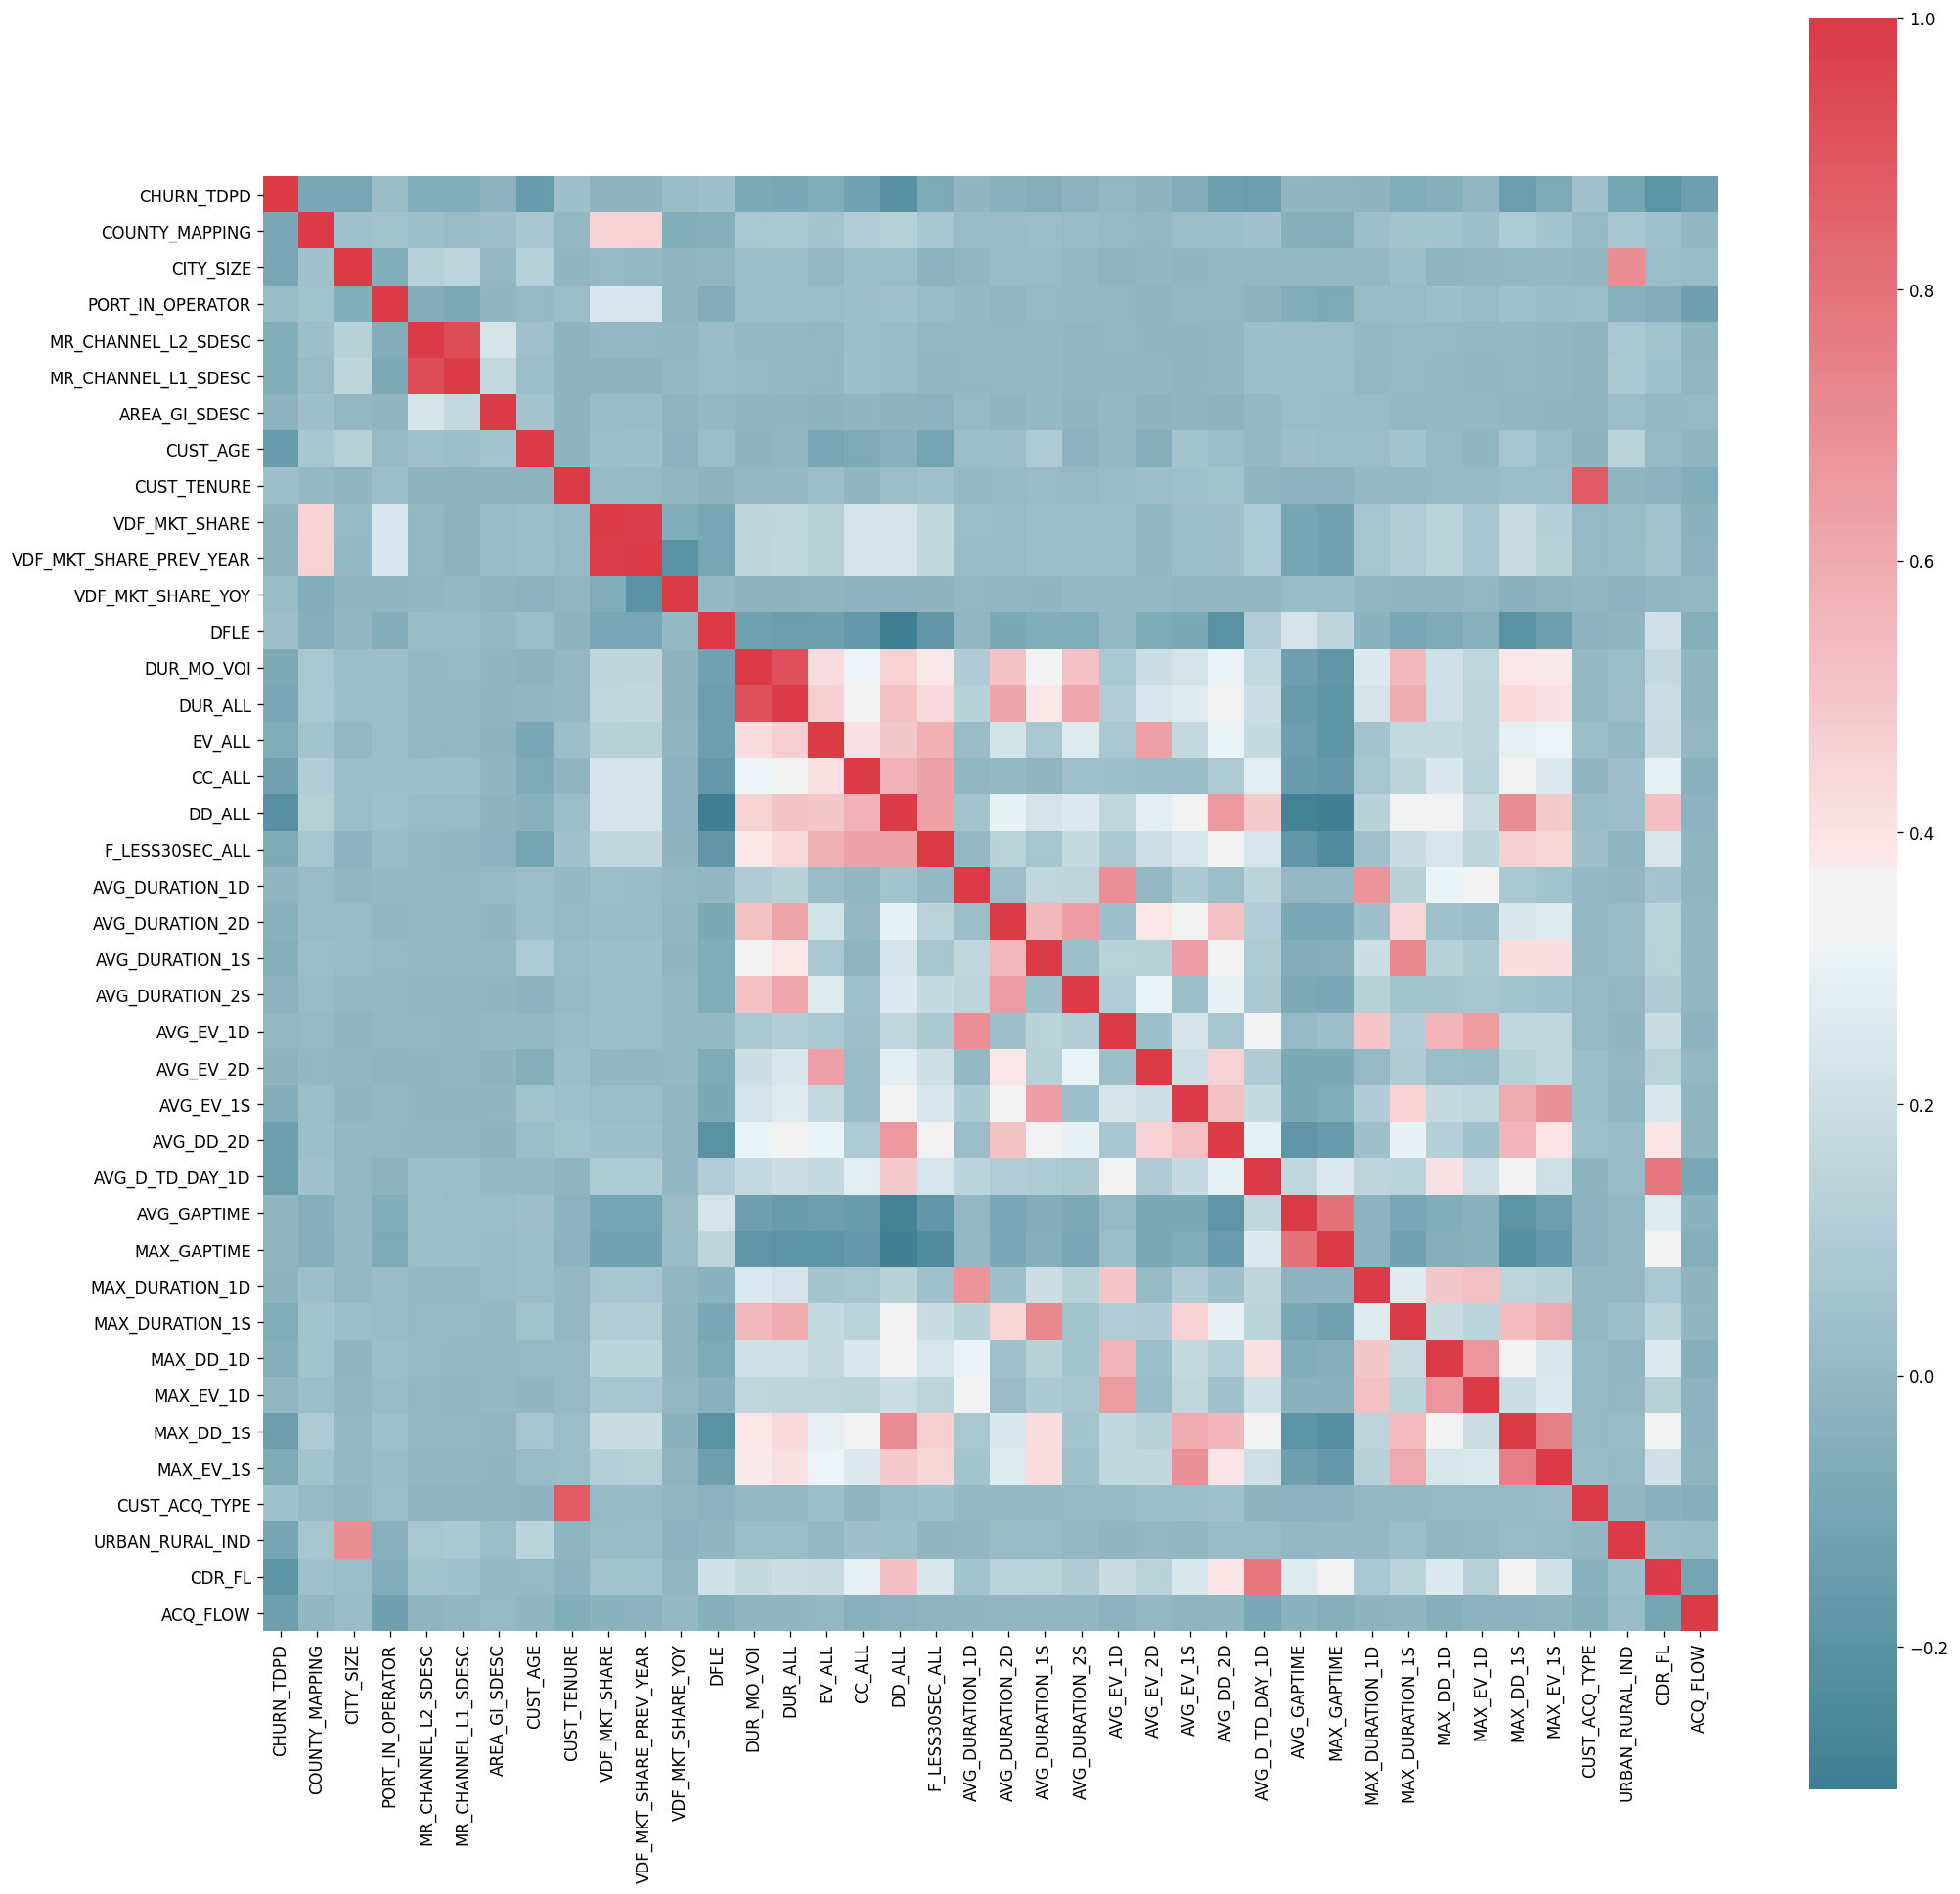

In [4]:
f, ax = plt.subplots(figsize=(20, 20), dpi=120)
corr = train_df[[y_col] + x_cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [5]:
model = XGBClassifier()
model.fit(train_df[x_cols], train_df[y_col],
          eval_set=[(valid_df[x_cols], valid_df[y_col])],
          eval_metric='logloss', early_stopping_rounds=20, verbose=True)

[0]	validation_0-logloss:0.53589
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.45030
[2]	validation_0-logloss:0.40028
[3]	validation_0-logloss:0.36922
[4]	validation_0-logloss:0.34973
[5]	validation_0-logloss:0.33600
[6]	validation_0-logloss:0.32738
[7]	validation_0-logloss:0.32123
[8]	validation_0-logloss:0.31684
[9]	validation_0-logloss:0.31400
[10]	validation_0-logloss:0.31226
[11]	validation_0-logloss:0.31037
[12]	validation_0-logloss:0.30977
[13]	validation_0-logloss:0.30928
[14]	validation_0-logloss:0.30845
[15]	validation_0-logloss:0.30839
[16]	validation_0-logloss:0.30801
[17]	validation_0-logloss:0.30717
[18]	validation_0-logloss:0.30696
[19]	validation_0-logloss:0.30642
[20]	validation_0-logloss:0.30641
[21]	validation_0-logloss:0.30624
[22]	validation_0-logloss:0.30533
[23]	validation_0-logloss:0.30535
[24]	validation_0-logloss:0.30535
[25]	validation_0-logloss:0.30525
[26]	validation_0-logloss:0.30528
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
y_train_pred = model.predict_proba(train_df[x_cols], ntree_limit=model.get_booster().best_ntree_limit)[:, 1]
y_valid_pred = model.predict_proba(valid_df[x_cols], ntree_limit=model.get_booster().best_ntree_limit)[:, 1]
y_test_pred = model.predict_proba(test_df[x_cols], ntree_limit=model.get_booster().best_ntree_limit)[:, 1]
y_oot_pred = model.predict_proba(oot_df[x_cols], ntree_limit=model.get_booster().best_ntree_limit)[:, 1]

print("ROC AUC Score (Train): %f" % metrics.roc_auc_score(train_df[y_col], y_train_pred))
print("ROC AUC Score (Valid): %f" % metrics.roc_auc_score(valid_df[y_col], y_valid_pred))
print("ROC AUC Score (Test): %f" % metrics.roc_auc_score(test_df[y_col], y_test_pred))
print("ROC AUC Score (Out of Time): %f" % metrics.roc_auc_score(oot_df[y_col], y_oot_pred))

ROC AUC Score (Train): 0.897740
ROC AUC Score (Valid): 0.813218
ROC AUC Score (Test): 0.813927
ROC AUC Score (Out of Time): 0.792368


Text(0, 0.5, 'feature')

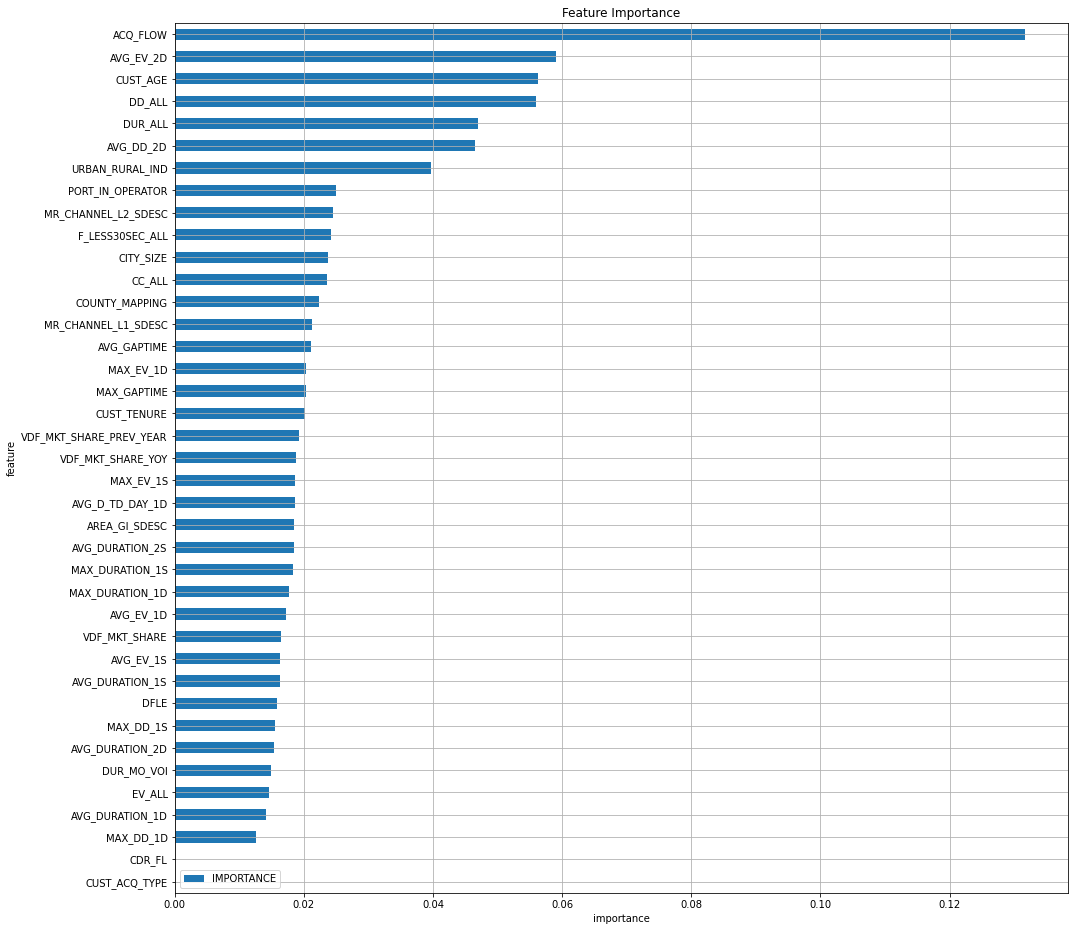

In [7]:
fimp_df = pd.DataFrame({'IMPORTANCE': model.feature_importances_}, index=x_cols)
ax = fimp_df.sort_values(by='IMPORTANCE').plot(
    kind='barh', figsize=(16, 16), grid=True, title='Feature Importance')
ax.set_xlabel("importance")
ax.set_ylabel("feature")

In [8]:
scores = dict(LOGLOSS=[], THRESHOLD=[])
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train_df[x_cols])
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(select_X_train, label=train_df[y_col])
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'],
                      nfold=10, metrics='logloss', early_stopping_rounds=20)
    logloss = cvresult['test-logloss-mean'].values[-1]
    scores['THRESHOLD'].append(thresh)
    scores['LOGLOSS'].append(logloss)
    print("(logloss) crosval 10: %.4f - thresh=%.4f - n=%d" % (logloss, thresh, select_X_train.shape[1]))

(logloss) crosval 10: 0.3023 - thresh=0.0000 - n=39
(logloss) crosval 10: 0.3023 - thresh=0.0000 - n=39
(logloss) crosval 10: 0.3023 - thresh=0.0125 - n=37
(logloss) crosval 10: 0.3028 - thresh=0.0141 - n=36
(logloss) crosval 10: 0.3024 - thresh=0.0146 - n=35
(logloss) crosval 10: 0.3015 - thresh=0.0150 - n=34
(logloss) crosval 10: 0.3024 - thresh=0.0154 - n=33
(logloss) crosval 10: 0.3028 - thresh=0.0156 - n=32
(logloss) crosval 10: 0.3020 - thresh=0.0158 - n=31
(logloss) crosval 10: 0.3022 - thresh=0.0163 - n=30
(logloss) crosval 10: 0.3016 - thresh=0.0164 - n=29
(logloss) crosval 10: 0.3017 - thresh=0.0165 - n=28
(logloss) crosval 10: 0.3012 - thresh=0.0172 - n=27
(logloss) crosval 10: 0.3020 - thresh=0.0176 - n=26
(logloss) crosval 10: 0.3021 - thresh=0.0184 - n=25
(logloss) crosval 10: 0.3018 - thresh=0.0184 - n=24
(logloss) crosval 10: 0.3015 - thresh=0.0185 - n=23
(logloss) crosval 10: 0.3028 - thresh=0.0186 - n=22
(logloss) crosval 10: 0.3025 - thresh=0.0186 - n=21
(logloss) cr

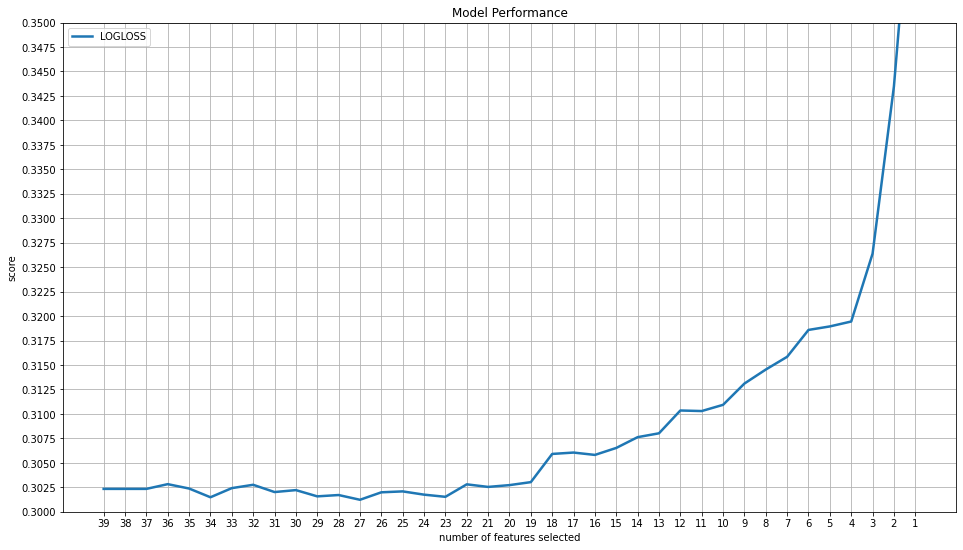

In [18]:
scores_df = pd.DataFrame(scores, index=[i for i in range(len(scores['THRESHOLD']), 0, -1)])
ax = scores_df[['LOGLOSS']].plot(figsize=(16, 9), grid=False, linewidth=2.5, title='Model Performance')
ax.grid(which='both')
ax.set_xticks(scores_df.index)
ax.set_yticks(np.arange(0.30, 0.40, 0.0025))
ax.set_ylim(bottom=0.30, top=0.35)
ax.set_xlabel("number of features selected")
ax.set_ylabel("score")
plt.gca().invert_xaxis()
plt.show()

In [19]:
scores = dict(TRAIN=[], VALID=[], TEST=[], OOT=[], THRESHOLD=[])

thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train_df[x_cols])
    select_X_valid = selection.transform(valid_df[x_cols])
    select_X_test = selection.transform(test_df[x_cols])
    select_X_oot = selection.transform(oot_df[x_cols])
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, train_df[y_col],
                        eval_set=[(select_X_valid, valid_df[y_col])],
                        eval_metric='logloss', early_stopping_rounds=20, verbose=False)
    # eval model
    best_iter = selection_model.get_booster().best_ntree_limit
    y_train_pred = selection_model.predict_proba(select_X_train, ntree_limit=best_iter)[:, 1]
    y_valid_pred = selection_model.predict_proba(select_X_valid, ntree_limit=best_iter)[:, 1]
    y_test_pred = selection_model.predict_proba(select_X_test, ntree_limit=best_iter)[:, 1]
    y_oot_pred = selection_model.predict_proba(select_X_oot, ntree_limit=best_iter)[:, 1]
    
    train_roc_auc = metrics.roc_auc_score(train_df[y_col], y_train_pred)
    valid_roc_auc = metrics.roc_auc_score(valid_df[y_col], y_valid_pred)
    test_roc_auc = metrics.roc_auc_score(test_df[y_col], y_test_pred)
    oot_roc_auc = metrics.roc_auc_score(oot_df[y_col], y_oot_pred)
    
    scores['THRESHOLD'].append(thresh)
    scores['TRAIN'].append(train_roc_auc)
    scores['VALID'].append(valid_roc_auc)
    scores['TEST'].append(test_roc_auc)
    scores['OOT'].append(oot_roc_auc)
    
    print("(roc auc) train: %.4f - valid: %.4f - test: %.4f - oot: %.4f - thresh=%.4f - n=%d" % (
        train_roc_auc, valid_roc_auc, test_roc_auc, oot_roc_auc, thresh, select_X_train.shape[1]))

(roc auc) train: 0.8977 - valid: 0.8132 - test: 0.8139 - oot: 0.7924 - thresh=0.0000 - n=39
(roc auc) train: 0.8977 - valid: 0.8132 - test: 0.8139 - oot: 0.7924 - thresh=0.0000 - n=39
(roc auc) train: 0.8977 - valid: 0.8132 - test: 0.8139 - oot: 0.7924 - thresh=0.0125 - n=37
(roc auc) train: 0.8991 - valid: 0.8151 - test: 0.8128 - oot: 0.7900 - thresh=0.0141 - n=36
(roc auc) train: 0.9046 - valid: 0.8137 - test: 0.8162 - oot: 0.7954 - thresh=0.0146 - n=35
(roc auc) train: 0.8860 - valid: 0.8151 - test: 0.8117 - oot: 0.7921 - thresh=0.0150 - n=34
(roc auc) train: 0.8978 - valid: 0.8151 - test: 0.8136 - oot: 0.7952 - thresh=0.0154 - n=33
(roc auc) train: 0.9059 - valid: 0.8143 - test: 0.8179 - oot: 0.7949 - thresh=0.0156 - n=32
(roc auc) train: 0.8924 - valid: 0.8106 - test: 0.8143 - oot: 0.7981 - thresh=0.0158 - n=31
(roc auc) train: 0.9033 - valid: 0.8125 - test: 0.8162 - oot: 0.7946 - thresh=0.0163 - n=30
(roc auc) train: 0.9064 - valid: 0.8136 - test: 0.8136 - oot: 0.7957 - thresh=0.

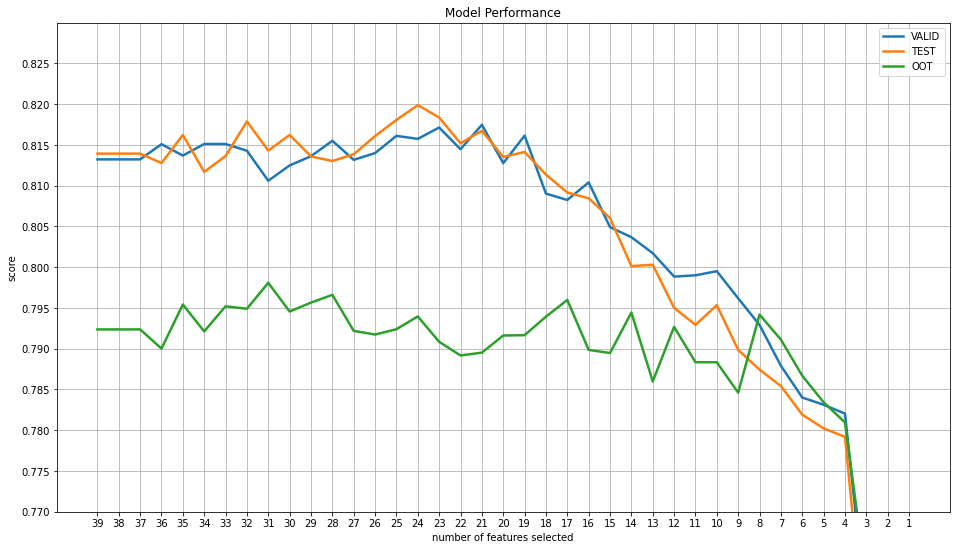

In [24]:
scores_df = pd.DataFrame(scores, index=[i for i in range(len(scores['THRESHOLD']), 0, -1)])
ax = scores_df[['VALID', 'TEST', 'OOT']].plot(
    figsize=(16, 9), grid=False, linewidth=2.5, title='Model Performance')
ax.grid(which='both')
ax.set_xticks(scores_df.index)
ax.set_yticks(np.arange(0.77, 0.83, 0.005))
ax.set_ylim(bottom=0.77, top=0.83)
ax.set_xlabel("number of features selected")
ax.set_ylabel("score")
plt.gca().invert_xaxis()
plt.show()

In [25]:
fimp_df.sort_values(by='IMPORTANCE', ascending=False)

,IMPORTANCE
ACQ_FLOW,0.131667
AVG_EV_2D,0.059006
CUST_AGE,0.056228
DD_ALL,0.056002
DUR_ALL,0.047009
AVG_DD_2D,0.046518
URBAN_RURAL_IND,0.039676
PORT_IN_OPERATOR,0.024936
MR_CHANNEL_L2_SDESC,0.024516
F_LESS30SEC_ALL,0.024176
